In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [3]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [5]:
# replicating May 3 2022 simulation setup
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

time_limit = 500
time_step = 5
transcript_lens = [100]
cellular_transcript_copy_number = [100]
gfp_transcript_copy_number = 10
ribosome_copy_number = 100
total_trna = 100
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 1 # may need to change this
ribosome_footprint = 15

date = "jan-30-2024-a"

### original parameters from May 3 2022 (single transcript population, sometimes see expression optima)

- time_limit = 500
- time_step = 5
- transcript_len = 100
- trna_props = [1, 2, 5, 10, 20, 30, 40, 45, 48, 49, 50, 51, 52, 55, 60, 70, 80, 90, 95, 98, 99]
- codon_comps = range(1, 100)
- transcript_copy_number = 100
- ribosome_copy_number = 100
- total_trna = 100
- ribosome_binding_rate = 100000.0
- trna_charging_rates = [10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

In [73]:
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

time_limit = 500
time_step = 5
transcript_lens = [100]
cellular_transcript_copy_number = [100]
gfp_transcript_copy_number = 10
ribosome_copy_number = 100
total_trna = 100
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 # increase ribosome speed
ribosome_footprint = 15

date = "jan-30-2024-b"

In [21]:
!mkdir ../yaml/jan-30-2024-b
!mkdir ../output/jan-30-2024-b

mkdir: cannot create directory ‘../yaml/jan-30-2024-b’: File exists
mkdir: cannot create directory ‘../output/jan-30-2024-b’: File exists


In [22]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")
        
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in cellular_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [74]:
df_master = None
for copy_number in cellular_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.7_0.3" + \
                   f"_{copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_0.01_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_comp is not None:
                df_comp = df_comp.append(tmp, ignore_index=True)
            else:
                df_comp = tmp
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3179939/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_3179939/3683003292.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


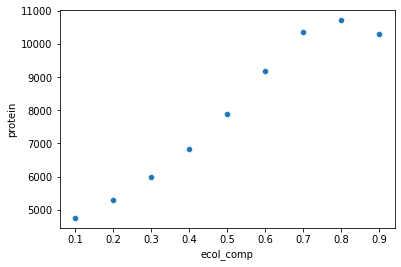

In [75]:
df = df_master[(df_master.species == "cellularProtein")]
df = df[(df.copy_number == 100)]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

In [76]:
# Revert species counts back to realistic cellular ratios
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

time_limit = 500
time_step = 5
transcript_lens = [100]
cellular_transcript_copy_number = [100]
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "jan-30-2024-c"

In [28]:
!mkdir ../yaml/jan-30-2024-c
!mkdir ../output/jan-30-2024-c

In [29]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")
        
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in cellular_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [77]:
df_master = None
for copy_number in cellular_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.7_0.3" + \
                   f"_{copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_0.01_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_comp is not None:
                df_comp = df_comp.append(tmp, ignore_index=True)
            else:
                df_comp = tmp
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3179939/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_3179939/3683003292.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


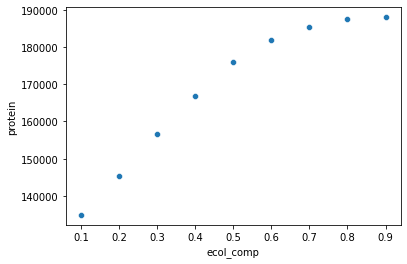

In [78]:
df = df_master[(df_master.species == "cellularProtein")]
df = df[(df.copy_number == 100)]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

In [13]:
# Now, decrease charging rate
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

time_limit = 500
time_step = 5
transcript_lens = [1000]
cellular_transcript_copy_number = [100]
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 10.0 # using lower charging rate
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "jan-30-2024-d"

In [42]:
!mkdir ../yaml/jan-30-2024-d
!mkdir ../output/jan-30-2024-d

mkdir: cannot create directory ‘../yaml/jan-30-2024-d’: File exists
mkdir: cannot create directory ‘../output/jan-30-2024-d’: File exists


In [43]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")
        
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in cellular_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [80]:
df_master = None
for copy_number in cellular_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.7_0.3" + \
                   f"_{copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_0.01_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_comp is not None:
                df_comp = df_comp.append(tmp, ignore_index=True)
            else:
                df_comp = tmp
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3179939/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_3179939/3683003292.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


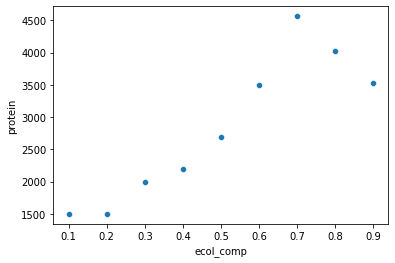

In [81]:
df = df_master[(df_master.species == "cellularProtein")]
df = df[(df.copy_number == 100)]
g = sns.lineplot(data=df, x = "ecol_comp", y = "protein")

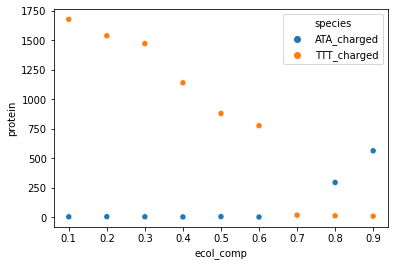

In [82]:
df = df_master[(df_master.species == "TTT_charged") | (df_master.species == "ATA_charged")]
df = df[(df.copy_number == 100)]
g = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="species")

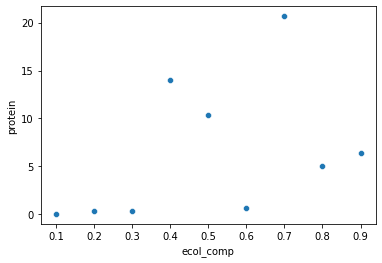

In [48]:
df = df_master[(df_master.species == "free ribosome")]
df = df[(df.copy_number == 100)]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

In [17]:
# Now, run sweep of charging rates 10^1 to 5*10^2
ecol_mrna_composition = [(x/100, round(1 - (x/100), 2)) for x in range(1, 100)]

time_limit = 200
time_step = 5
transcript_lens = [1000]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
#ecol_rbs_rate = [1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
ribosome_binding_rate = 0.01
trna_charging_rate = [10.0, 50.0, 100.0, 500.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-1-2024"

In [63]:
!mkdir ../yaml/feb-1-2024
!mkdir ../output/feb-1-2024

In [64]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [69]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for charging_rate in trna_charging_rate:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {binding_rate} {ribosome_binding_rate} {charging_rate} {charging_rate} " + \
                  f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                stream.write(cmd)
                stream.write("\n")

In [8]:
df_master = None
for copy_number in cellular_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            df_codon = None
            for chrg_rate in trna_charging_rate:
                path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.7_0.3" + \
                       f"_{copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_0.01_{chrg_rate}_{chrg_rate}"
                tmp = get_average_protein(path, 0.5, 200, 3)
                tmp["charging_rate"] = chrg_rate
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_codon is not None:
                    df_codon = df_codon.append(tmp, ignore_index=True)
                else:
                    df_codon = tmp
            df_codon["codon"] = float(codons[0])
            if df_comp is not None:
                df_comp = df_comp.append(df_codon, ignore_index=True)
            else:
                df_comp = df_codon
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_58625/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_58625/2354336541.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


Text(0, 0.5, 'Charged pref. tRNA')

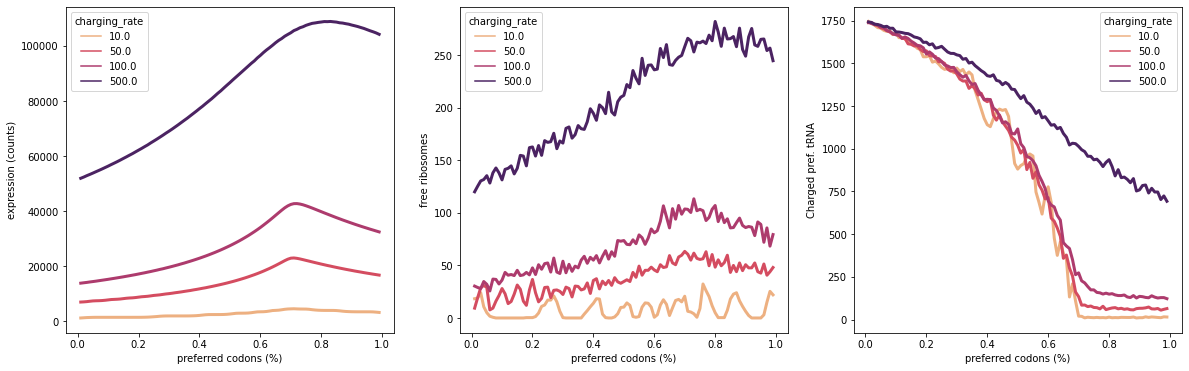

In [10]:
norm = LogNorm()
rcParams['figure.figsize'] = [20, 6]
fig, ax = plt.subplots(1, 3)

df = df_master[(df_master.species == "cellularProtein")]
df = df[(df.copy_number == 100)]
g1 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[0])
g1.set_xlabel("preferred codons (%)")
g1.set_ylabel("expression (counts)")

norm = LogNorm()
df = df_master[(df_master.species == "free ribosome")]
df = df[(df.copy_number == 100)]
g2 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[1])
g2.set_xlabel("preferred codons (%)")
g2.set_ylabel("free ribosomes")

norm = LogNorm()
df = df_master[(df_master.species == "TTT_charged")]
df = df[(df.copy_number == 100)]
g = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[2])
plt.xlabel("preferred codons (%)")
plt.ylabel("Charged pref. tRNA")

Text(0, 0.5, 'Charged rare tRNA')

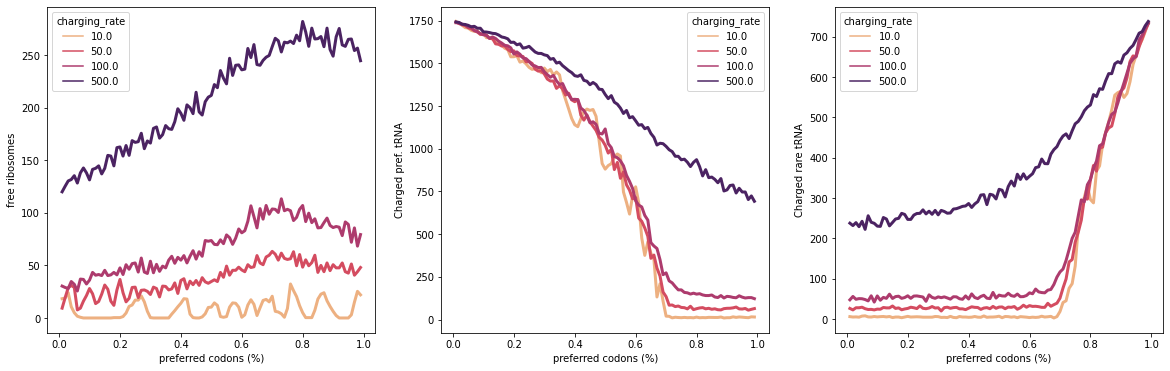

In [12]:
rcParams['figure.figsize'] = [20, 6]
fig, ax = plt.subplots(1, 3)

norm = LogNorm()
df = df_master[(df_master.species == "free ribosome")]
df = df[(df.copy_number == 100)]
g1 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[0])
g1.set_xlabel("preferred codons (%)")
g1.set_ylabel("free ribosomes")

norm = LogNorm()
df = df_master[(df_master.species == "TTT_charged")]
df = df[(df.copy_number == 100)]
g2 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[1])
g2.set_xlabel("preferred codons (%)")
g2.set_ylabel("Charged pref. tRNA")

df = df_master[(df_master.species == "ATA_charged")]
df = df[(df.copy_number == 100)]
g3 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[2])
g3.set_xlabel("preferred codons (%)")
g3.set_ylabel("Charged rare tRNA")

In [16]:
df = df_master[(df_master.species == "cellularProtein")]
df.to_csv("single_transcript_exp.csv")

In [23]:
# Now, run sweep of charging rates 10^1 to 5*10^2 & binding rates 10^3 to 10^5
ecol_mrna_composition = [(x/100, round(1 - (x/100), 2)) for x in range(1, 100)]

time_limit = 200
time_step = 5
transcript_lens = [1000]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
#ecol_rbs_rate = [100000.0]
ecol_rbs_rate = [1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
ribosome_binding_rate = 0.001
trna_charging_rate = [10.0, 50.0, 100.0, 250.0, 500.0, 1000.0, 5000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-27-2024"

In [27]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [29]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for binding_rate in ecol_rbs_rate:
            for charging_rate in trna_charging_rate:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {binding_rate} {ribosome_binding_rate} {charging_rate} {charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [25]:
!mkdir ../yaml/feb-27-2024
!mkdir ../output/feb-27-2024